In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge, ARDRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE


from sklearn.cross_validation import LabelKFold
from ml_metrics import rmsle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])

In [3]:
def select_features(data):
    black_list = ['casual', 'registered', 'count', 'is_test', 'datetime']
    return [feat for feat in data.columns if feat not in black_list]
    
def get_X_y(data, target_var='count'):
    features = select_features(data)
    return data[features].values, data[target_var].values

def validation(data, n_folds=3):
    feats = select_features(data)
    X = data[feats].values
    y = data['count'].values

    labels = data['datetime'].dt.month.values
    
    for train_idx, test_idx in LabelKFold(labels, n_folds=n_folds):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def get_importance_features(data, model, limit, target_variable):
    X,y = get_X_y(data, target_variable)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort_values(by=[0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=30, target_variable='count'):
    feats = get_importance_features(data, model, limit, target_variable)
    feats.plot(kind='bar', figsize=(20, 8), title="Target variable = {0}".format(target_variable))
    
    
def count_modeling(model, data, feats, n_folds=3):
    X,y  = data[feats].values, data['count'].values

    labels = data['datetime'].dt.month.values
    
    scores = []
    for train_idx, test_idx in LabelKFold(labels, n_folds=n_folds):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        y_pred[y_pred <0 ] = 0
        scores.append(rmsle(y[test_idx], y_pred))
        
    return np.mean(scores), np.std(scores)

## Feature Engineering

There're different type of variables:
- numerical (integer or float)
    - put into different buckets, e.g. you can split age in number into buckets: **children**, **teenagers**, **adults**, **old**
- categorical (e.g. colours blue, white, black)
    - convert into numerical, e.g. a, b, c => 0, 1, 2
    - one hot encoding: crate from one column, n-columns binary, where n is count of unique value
    - convert into probability
- date|datetime
    - extract day, month, year
    - get extra information from excracted parts for day, e.g. is_wekeend, is_holiday in given country and so on

In [4]:
def cat_hour(hour):
    if 5 >= hour < 10:
        return 1#morning
    elif 10 >= hour < 17:
        return 2#day
    elif 17 >= hour < 23:
        return 3 #evening
    else:
        return 4 #night
    
def feature_engineering(data):
    data['year'] = data['datetime'].dt.year
    # you cand add: month, day, hour, minute, dayofweek, weekofyear
    
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['minute'] = data['datetime'].dt.minute
    data['dayofweek'] = data['datetime'].dt.dayofweek
    data['weekofyear'] = data['datetime'].dt.weekofyear
    

    #you can think in this way as well:
    data['weekend'] = data.dayofweek.map(lambda x: int(x in [5,6]) )
    data['time_of_day'] = data['hour'].map(cat_hour)
    
    
feature_engineering(train)

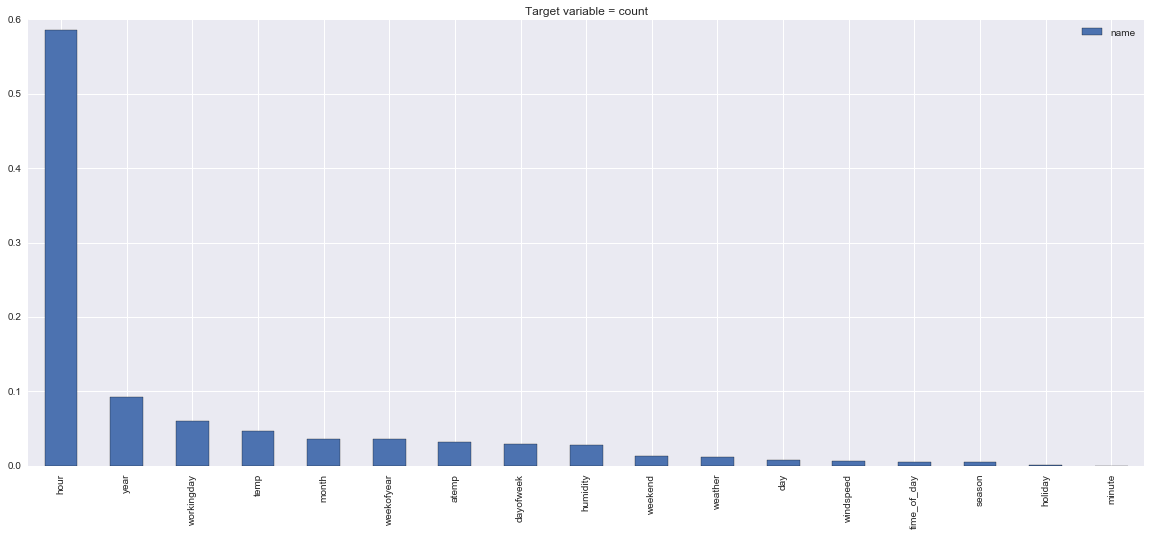

In [5]:
draw_importance_features(train, target_variable='count')

In [6]:
model = RandomForestRegressor()
feats = select_features(train)
score, score_std = count_modeling(model, train, feats)

print("score={0}, score_std={1}".format(round(score, 5), round(score, 4)))

score=0.39816, score_std=0.3982


## Feature Selection
Remember the ideal score is 0.

In [7]:
feats = select_features(train)

treshold = .6
sel = VarianceThreshold(threshold=(treshold * (1 - treshold)))
sel.fit_transform(train[feats], train['count']).shape

current_feats = np.array(feats)[sel.get_support()]
removed_feats = list(set(np.array(feats)) - set(current_feats))

print("removed features: {0}\n\ncurrent features{1}".format(removed_feats, current_feats))

removed features: ['holiday', 'weekend', 'minute', 'workingday']

current features['season' 'weather' 'temp' 'atemp' 'humidity' 'windspeed' 'year' 'month'
 'day' 'hour' 'dayofweek' 'weekofyear' 'time_of_day']


In [10]:
def find_the_best_features(data, sel_class, model=RandomForestRegressor(), verbose=True, range_k = range(2, 17), show_top=5):
    feats = select_features(data)
    X,y = data[feats], data['count']

    results = []
    for k in range_k:
        sel = sel_class(k)
        X_new = sel.fit_transform(X, y)

        current_feats = np.array(feats)[sel.get_support()]
        mean_score, std_score = (count_modeling(model, train, current_feats))
        if verbose:
            print("score={0}, std-score{1}, features#{2}: {3}".format(round(mean_score, 5), round(std_score, 4), len(current_feats), current_feats ))
        
        results.append( (mean_score, std_score, current_feats) )

    return sorted(results, key=lambda x: x[0])[:show_top]

In [11]:
_ = find_the_best_features(train, lambda k: SelectKBest(chi2, k))

score=0.81472, std-score0.0206, features#2: ['humidity' 'hour']
score=0.79216, std-score0.0351, features#3: ['humidity' 'hour' 'weekofyear']
score=0.75718, std-score0.0377, features#4: ['temp' 'humidity' 'hour' 'weekofyear']
score=0.74501, std-score0.0248, features#5: ['temp' 'atemp' 'humidity' 'hour' 'weekofyear']
score=0.74925, std-score0.0333, features#6: ['temp' 'atemp' 'humidity' 'windspeed' 'hour' 'weekofyear']
score=0.74365, std-score0.0241, features#7: ['temp' 'atemp' 'humidity' 'windspeed' 'hour' 'weekofyear' 'time_of_day']
score=0.75235, std-score0.0276, features#8: ['temp' 'atemp' 'humidity' 'windspeed' 'day' 'hour' 'weekofyear'
 'time_of_day']
score=0.73115, std-score0.0061, features#9: ['temp' 'atemp' 'humidity' 'windspeed' 'month' 'day' 'hour' 'weekofyear'
 'time_of_day']
score=0.50574, std-score0.0132, features#10: ['temp' 'atemp' 'humidity' 'windspeed' 'month' 'day' 'hour' 'dayofweek'
 'weekofyear' 'time_of_day']
score=0.50623, std-score0.0053, features#11: ['temp' 'ate

In [12]:
_ = find_the_best_features(train, lambda k: RFE(model, k, step=1))

score=0.73926, std-score0.0147, features#2: ['temp' 'hour']
score=0.55187, std-score0.0131, features#3: ['temp' 'hour' 'dayofweek']
score=0.52884, std-score0.0195, features#4: ['atemp' 'month' 'hour' 'dayofweek']
score=0.43494, std-score0.0123, features#5: ['temp' 'year' 'month' 'hour' 'dayofweek']
score=0.41476, std-score0.0081, features#6: ['workingday' 'temp' 'humidity' 'year' 'month' 'hour']
score=0.4106, std-score0.017, features#7: ['workingday' 'temp' 'atemp' 'year' 'month' 'hour' 'dayofweek']
score=0.41353, std-score0.0291, features#8: ['workingday' 'temp' 'atemp' 'humidity' 'year' 'hour' 'dayofweek'
 'weekofyear']
score=0.39899, std-score0.0124, features#9: ['workingday' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour' 'dayofweek'
 'weekofyear']
score=0.38702, std-score0.0131, features#10: ['workingday' 'weather' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour'
 'dayofweek' 'weekofyear']
score=0.38799, std-score0.0144, features#11: ['workingday' 'weather' 'temp' 'atemp' 'humidity

## Model Selection

In [17]:
models = [ 
    ('extra_tree', ExtraTreesRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('bagging', BaggingRegressor()),
    ('ada boost', AdaBoostRegressor()),
    ('gradient boosting', GradientBoostingRegressor()),
    ('decision tree', DecisionTreeRegressor())
]


    
for model_name, model in models:
    try:
        results = find_the_best_features(train, lambda k: RFE(model, k, step=1), model=model, verbose=False) #working for trees models
    except RuntimeError:
        results = find_the_best_features(train, lambda k: SelectKBest(chi2, k), model=model, verbose=False)
    the_best_features = results[0][2]
    
    mean_score, std_score = count_modeling(model, train, the_best_features)
    print("model_name={0}: score={1}, features={2}".format(model_name, mean_score, the_best_features))
    print("")


model_name=extra_tree: score=0.389621006158, features=['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed' 'year' 'month' 'day' 'hour' 'dayofweek' 'weekofyear' 'weekend'
 'time_of_day']

model_name=random_forest: score=0.389502295722, features=['workingday' 'weather' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour'
 'dayofweek' 'weekofyear' 'weekend']

model_name=bagging: score=0.406878732047, features=['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed' 'year' 'month' 'day' 'hour' 'dayofweek' 'weekofyear' 'weekend'
 'time_of_day']

model_name=ada boost: score=0.906486451256, features=['temp' 'year' 'hour']

model_name=gradient boosting: score=0.652704765137, features=['workingday' 'atemp' 'hour']

model_name=decision tree: score=0.490577485883, features=['workingday' 'atemp' 'humidity' 'year' 'month' 'hour' 'dayofweek'
 'weekofyear']



## Questions
1. Which model is the fastest/slowest for learning?
2. Which model is the fastest/slowest for predicting?
3. Which model provide the best/worst score?

# For more advanced

## Future Engineering
What do you think about grouping something?

Example:

In [52]:
group_train = train[ ['count', 'season'] ].groupby('season').agg(np.mean).reset_index().rename(columns={'count': 'season_group'})
train = pd.merge(train, group_train, on=['season'])

Remember about `casual` and `registered`, so you can predict it separetly and summary later (count = casual + registered)

Remember about logarithm transformation. Much better is learn/fit & predict log_count and later transform to count.

## Model Selection

What about xgboost?

In [87]:
import xgboost as xgb

model = xgb.XGBRegressor()
#...

In [43]:
print("Are there missing values: ", train.isnull().values.any())

('Are there missing values: ', False)
